In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
%run plot.py

import keras
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l1, l2, l1_l2

### Load data

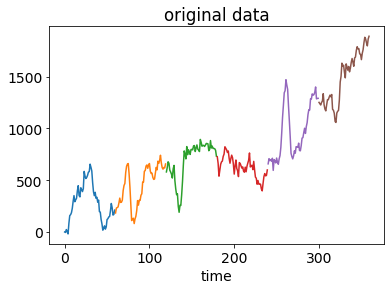

data:  10000
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [2]:
# A identifies the amplitude considered in the notebook
# The possibilities are: 300, 500
A = 500

str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
fnamex = 'DATA/x_' + str0
fnamey = 'DATA/y_' + str0

x = np.loadtxt(fnamex, delimiter=' ', dtype=float)
N, L = len(x), len(x[0])

Show_data(x, 6, 'original data')
print('data: ', N)

# build multi-class vector labels
categ = np.loadtxt(fnamey, dtype=int)
n_class = 3
y = np.zeros((N,n_class))
for i in range(N):
    y[i,categ[i]] = 1
print(y[:6])


### Rescale data

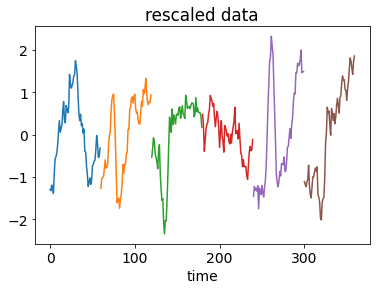

In [3]:
# remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i] - xm[i]

# rescale all the samples with the dataset variance 
xv = x.var()
x = x/np.sqrt(xv)
    
Show_data(x, 6, 'rescaled data')

### Split training, validation and test data

In [4]:
# number of training, validation and test data
perc_train = 0.5
perc_valid = 0.1
N_train = int(perc_train*N)
N_val = int(perc_valid*N)

x_train, y_train = x[0:N_train], y[0:N_train]
x_val, y_val = x[N_train:N_train+N_val], y[N_train:N_train+N_val]
x_test, y_test = x[N_train+N_val:], y[N_train+N_val:]

print('training:', len(x_train),'\nvalidation:', len(x_val), '\ntest:', len(x_test))

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

training: 5000 
validation: 1000 
test: 4000


### Define three different architectures with Keras

In [5]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# regularizer
reg = tf.keras.regularizers.l2(0.1)
# initializer
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# define 3 different models

# -----1-----
model1 = Sequential()
model1.add(Conv1D(filters=5, kernel_size=11, 
                    kernel_initializer=ini, 
                    kernel_regularizer=reg,
                    activation='relu', input_shape=input_shape))
model1.add(AveragePooling1D(5))
model1.add(Flatten())
model1.add(Dense(9, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(n_class, activation='softmax'))
model1.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer='Adam', metrics=['accuracy'])

# -----2-----
model2 = Sequential()
model2.add(Conv1D(filters=5, kernel_size=11, 
                    kernel_initializer=ini, 
                    kernel_regularizer=reg,
                    activation='relu', 
                    input_shape=input_shape))
model2.add(AveragePooling1D(5))
model2.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
model2.add(Flatten())
model2.add(Dense(12, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(n_class, activation='softmax'))
model2.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='Adam', metrics=['accuracy'])

# -----3-----
model3 = Sequential()
model3.add(Conv1D(filters=6, kernel_size=3,
                    kernel_initializer=ini, 
                    kernel_regularizer=reg,
                    activation='relu', 
                    input_shape=input_shape))
model3.add(Conv1D(filters=8, kernel_size=9,
                    activation='relu'))
model3.add(Conv1D(filters=4, kernel_size=3,
                    activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='Adam', metrics=['accuracy'])

In [6]:
print('----- Model 1 -----')
print(model1.summary())

print('----- Model 2 -----')
print(model2.summary())

print('----- Model 3 -----')
print(model3.summary())

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 9)                 459       
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 6)                 60        
                                    

### Define function to show the history and weigths

In [7]:
def Show_history(fit):
    fig, AX = plt.subplots(1,2,figsize=(12,5.))

    # plot accuracy
    ax = AX[0]
    ax.plot(fit.history['accuracy'], 'b', label='training')
    ax.plot(fit.history['val_accuracy'], 'r--', label='validation')
    ax.plot((0,len(fit.history['accuracy'])), (1/3,1/3), ':', c='gray', label='random choice')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([0, 1])
    ax.legend()

    # plot loss
    ax = AX[1]
    ax.plot(fit.history['loss'], 'b', label='training')
    ax.plot(fit.history['val_loss'], 'r--', label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()

    plt.show()

def Show_weights(model, l=0):
    # define colors and markers
    c = ['r','y','c','b','m','g','k']
    m = ['o','s','D','<','>','p','P']
    ms = 10
    
    # get weights
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    # get bias
    b = model.layers[l].get_weights()[1]
    
    fig, AX = plt.subplots(1,2,figsize=(12,4.4))

    # plot weights
    ax = AX[0]
    ax.axhline(0, c='k')
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i,0], '-', c=c[i], marker=m[i], label=str(i), markersize=ms)
    ax.set_title('Filters of layer ' + str(l+1))
    ax.set_xlabel('index')

    # plot bias
    ax = AX[1]
    ax.axhline(0, c='k')
    for i in range(M):
        ax.plot((i), (b[i]), c=c[i], marker=m[i], label='filter ' + str(i), markersize=ms)
    ax.set_title('Bias of layer ' + str(l+1))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()

    plt.show()

### Visualize weigths initialization

----- Model 1 -----


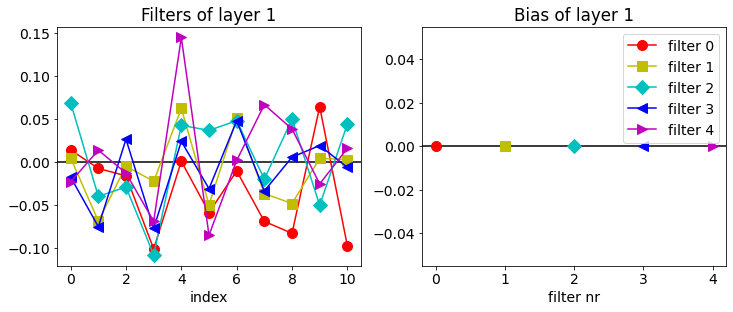

----- Model 2 -----


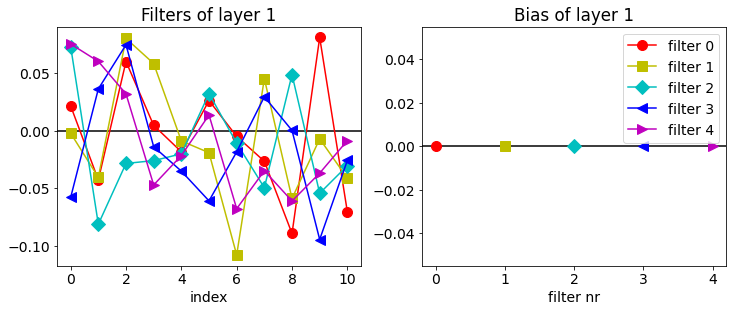

----- Model 3 -----


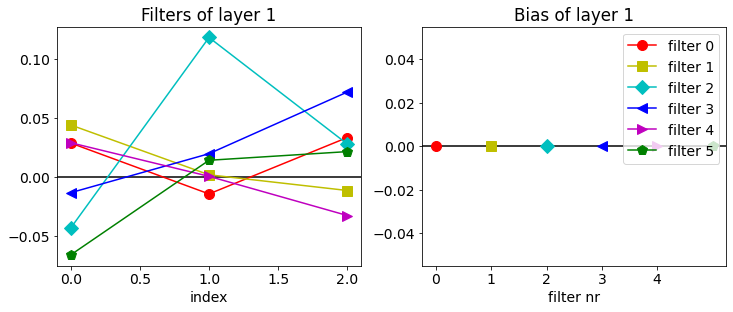

In [8]:
print('----- Model 1 -----')
Show_weights(model1,0)
print('----- Model 2 -----')
Show_weights(model2,0)
print('----- Model 3 -----')
Show_weights(model3,0)

### Training

In [9]:
# hyper-parameters
BATCH_SIZE = 256
EPOCHS = 128

print('----- Model 1 -----\nFITTING....')
fit1 = model1.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)

print('----- Model 2 -----\nFITTING....')
fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)
               
print('----- Model 3 -----\nFITTING....')            
fit3 = model3.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model 1 -----
FITTING....
Epoch 1/128
20/20 - 1s - loss: 1.1079 - accuracy: 0.3506 - val_loss: 1.1023 - val_accuracy: 0.3650 - 1s/epoch - 60ms/step
Epoch 2/128
20/20 - 0s - loss: 1.0977 - accuracy: 0.3804 - val_loss: 1.0925 - val_accuracy: 0.4260 - 161ms/epoch - 8ms/step
Epoch 3/128
20/20 - 0s - loss: 1.0902 - accuracy: 0.3958 - val_loss: 1.0815 - val_accuracy: 0.4450 - 137ms/epoch - 7ms/step
Epoch 4/128
20/20 - 0s - loss: 1.0766 - accuracy: 0.4324 - val_loss: 1.0679 - val_accuracy: 0.4690 - 135ms/epoch - 7ms/step
Epoch 5/128
20/20 - 0s - loss: 1.0646 - accuracy: 0.4274 - val_loss: 1.0509 - val_accuracy: 0.4780 - 148ms/epoch - 7ms/step
Epoch 6/128
20/20 - 0s - loss: 1.0461 - accuracy: 0.4590 - val_loss: 1.0295 - val_accuracy: 0.5270 - 156ms/epoch - 8ms/step
Epoch 7/128
20/20 - 0s - loss: 1.0314 - accuracy: 0.4958 - val_loss: 1.0082 - val_accuracy: 0.5730 - 142ms/epoch - 7ms/step
Epoch 8/128
20/20 - 0s - loss: 1.0140 - accuracy: 0.5220 - val_loss: 0.9887 - val_accuracy: 0.6230 - 1

### Show history and weights

----- Model 1 -----


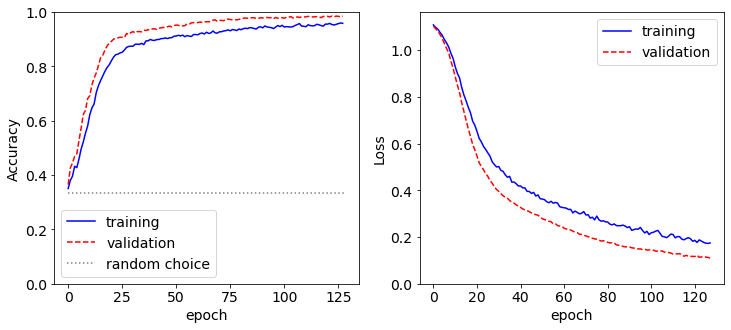

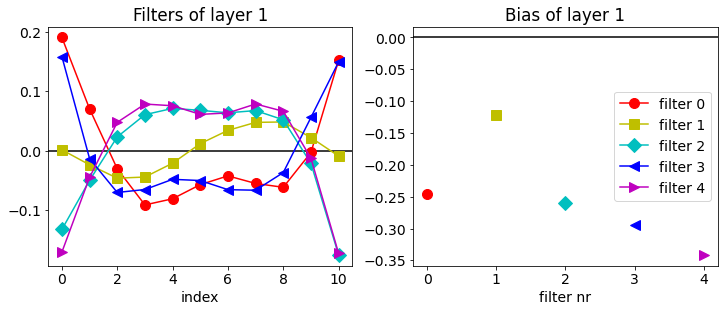

----- Model 2 -----


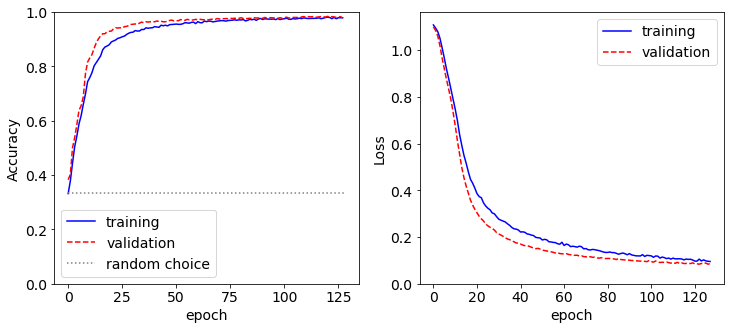

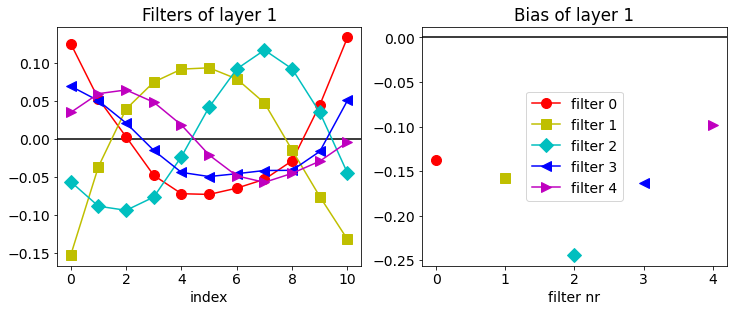

----- Model 3 -----


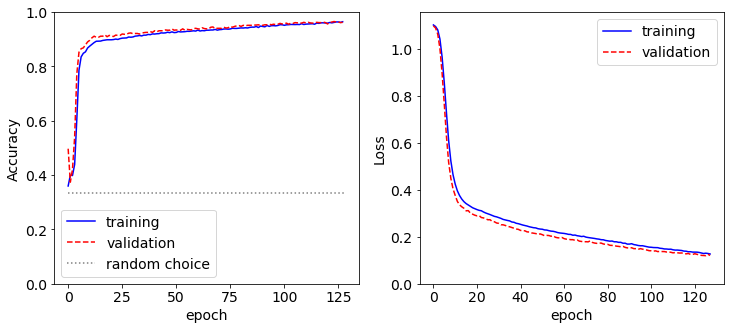

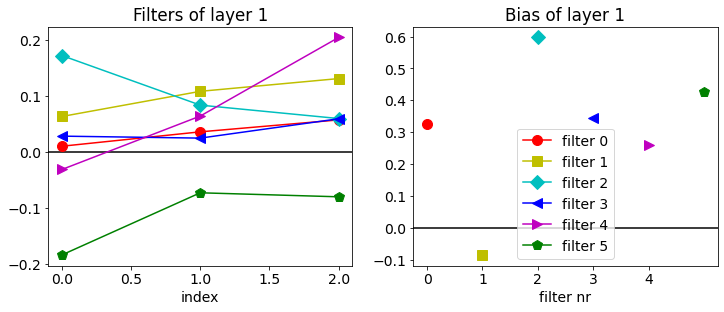

In [10]:
print('----- Model 1 -----')
Show_history(fit1)
Show_weights(model1,0)

print('----- Model 2 -----')
Show_history(fit2)
Show_weights(model2,0)

print('----- Model 3 -----')
Show_history(fit3)
Show_weights(model3,0)

### Confusion matrices on test set

----- Model 1 -----


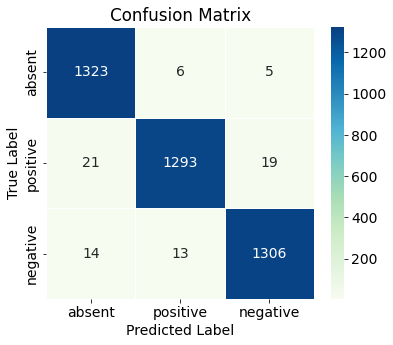

test accuracy: 0.9805 

----- Model 2 -----


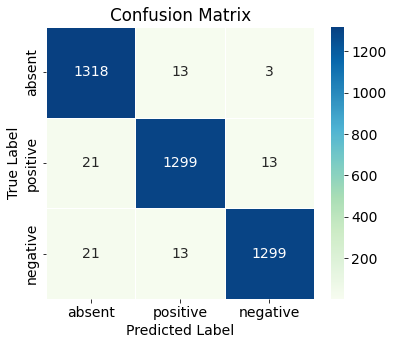

test accuracy: 0.979 

----- Model 3 -----


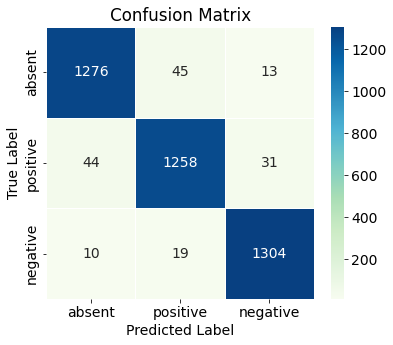

test accuracy: 0.9595


In [11]:
import pandas as pd
from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing


def show_confusion_matrix(test, pred):

    LABELS = ['absent','positive','negative']
    cmap='GnBu'

    cm = metrics.confusion_matrix(test, pred)
    
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(cm,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return cm

# true labels
max_y_test = np.argmax(y_test, axis=1)

# predicted labels: take the class with the highest probability

print('----- Model 1 -----')
y_pred1 = model1.predict(x_test)
max_y_pred1 = np.argmax(y_pred1, axis=1)
cm1 = show_confusion_matrix(max_y_test, max_y_pred1)
print('test accuracy:', np.sum(cm1[0,0] + cm1[1,1] + cm1[2,2])/len(max_y_pred1), '\n')

print('----- Model 2 -----')
y_pred2 = model2.predict(x_test)
max_y_pred2 = np.argmax(y_pred2, axis=1)
cm2 = show_confusion_matrix(max_y_test, max_y_pred2)
print('test accuracy:', np.sum(cm2[0,0] + cm2[1,1] + cm2[2,2])/len(max_y_pred2), '\n')

print('----- Model 3 -----')
y_pred3 = model3.predict(x_test)
max_y_pred3 = np.argmax(y_pred3, axis=1)
cm3 = show_confusion_matrix(max_y_test, max_y_pred3)
print('test accuracy:', np.sum(cm3[0,0] + cm3[1,1] + cm3[2,2])/len(max_y_pred3))

### DISCUSSION

As we can see from the above plots, performances are quite similar for different architectures using 1, 2 or 3 convolutional layer. In particular the third one has a really steep learning curve regarding validation accuracy, though test accuracy is not as good as expected (about 0.95).